In [ ]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 14.8 MB/s eta 0:00:00


In [ ]:
import argparse
import gymnasium as gym
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import pandas as pd



gamma=0.99

log_interval=10


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(7, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

#for trained testing: optimizer is loaded from checkpoint
model_trained = Policy()


# for untrained testing
model_untrained = Policy()
optimizer_untrained = optim.Adam(model_untrained.parameters(), lr=1e-2)


eps = np.finfo(np.float32).eps.item()


#####

env = gym.make("two-step-task-novel-v0", render_mode='human')

In [ ]:
# Load the checkpoint from Google Drive
path = "/content/drive/MyDrive/Models/folder_name/"

file_name_trained="best_checkpoint_atThreshold_2562.pth"
checkpoint_tarined = torch.load(f"{path}{file_name_trained}", weights_only=False)

# Load the model and optimizer state
optimizer = optim.Adam(policy.parameters())  # Recreate the optimizer with the same settings as before
policy.load_state_dict(checkpoint_tarined['model_state_dict'])
optimizer.load_state_dict(checkpoint_tarined['optimizer_state_dict'])
policy.train()



Policy(
  (affine1): Linear(in_features=8, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (affine2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
import pandas as pd


In [ ]:
# Function to test the trained policy
def test_policy(policy, env, num_episodes=100, render=False, nnType = 'Trained'):
    # Put the model in evaluation mode
    policy.eval()

    # Disable gradient calculations during inference
    with torch.no_grad():
        scores = []
        running_scores = []
        running_reward = 10
        # Step 1: Create an empty DataFrame with required columns, for plotting later
        df = pd.DataFrame(columns=['episode', 'trial_num', 'actionInS1', 'stateInS1',
                               'reward', 'score','p_win_state1_action','p_win_state2_action',
                               'stake'])
        for i in range(num_episodes):
            state = env.reset()[0]
            done = False
            score = 0
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            for t in range(1, 10000):
                if render:
                  env.render()

                # Convert state to tensor and send to device
                state_tensor = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)

                # Get action probabilities and hidden state from the policy
                action_probs = policy(state_tensor)

                # Sample action
                action_dist = Categorical(action_probs)
                action = action_dist.sample()

                df.loc[len(df), ['actionInS1','stateInS1']] = [action.item(), state[4:6]]

                next_state, reward, done, _, info = env.step(action.item())
                score += reward

                matrix=info["winning_matrix"]
                matrix= matrix.tolist()

                df.loc[len(df)-1, ['reward', 'score', 'p_win_state1_action', 'p_win_state2_action']]= [reward, score,
                                                          matrix[0], matrix[1]]

                df.loc[len(df)-1, ['episode', 'trial_num',  'stake']] = [i, info["number of trials"], info["stake"]]


                # Update state
                state = next_state

                if done:
                    break

            scores.append(score)
            print(f"Episode {i+1} finished with total reward: {score}")
            running_reward = 0.05 * score + (1 - 0.05) * running_reward  # Update running reward
            running_scores.append(running_reward)
            # Save to a CSV file
            df.to_csv(f'output_novel_testBiased_To1.csv', index=False)
            !mv   /content/output*.csv /content/drive/MyDrive/Models/folder/test_NN_NovelvsNormal/


    env.close()
    return  df




In [ ]:
# Test the trained policy and untrained NN
df_trained = test_policy(model_trained, env, num_episodes=100, render=True, nnType = 'Trained')
df_untrained = test_policy(model_untrained, env, num_episodes=100, render=True, nnType = 'Untrained')

Streaming output truncated to the last 5000 lines.
Blu   Gre 
      
  Age   

obs is [ 0  1  0  0  4  3  5 78]
Ora   Tur 
      
  Age   

obs is [  1   0   0   0   1   2   5 108]
Gre   Blu 
      
  Age   

obs is [  1   0   0   0   2   1   1 148]
Blu   Gre 
      
  Age   

obs is [  1   0   0   0   2   1   1 156]
Blu   Gre 
      
  Age   

obs is [  0   1   0   0   3   4   1 163]
Tur   Ora 
      
  Age   

obs is [  0   1   0   0   3   4   1 169]
Tur   Ora 
      
  Age   

obs is [  1   0   0   0   2   1   5 176]
Blu   Gre 
      
  Age   

obs is [  1   0   0   0   2   1   1 186]
Blu   Gre 
      
  Age   

obs is [  0   1   0   0   4   3   1 187]
Ora   Tur 
      
  Age   

obs is [  1   0   0   0   1   2   1 187]
Gre   Blu 
      
  Age   

obs is [  0   1   0   0   3   4   5 187]
Tur   Ora 
      
  Age   

obs is [  0   1   0   0   3   4   1 192]
Tur   Ora 
      
  Age   

obs is [  0   1   0   0   3   4   5 194]
Tur   Ora 
      
  Age   

obs is [  0   1   0   0   4   3 

In [ ]:

test_rewards_untrained , running_scores_untrained, df_untrained = test_policy(model_untrained, env, num_episodes=100, render=True, nnType = 'Untrained')

Streaming output truncated to the last 5000 lines.

AgentAction.RIGHT
1
obs is [  1   0   0   0   2   1   1 902]
Blu   Gre 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   1   2   1 908]
Gre   Blu 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   2   1   1 912]
Blu   Gre 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   1   2   1 919]
Gre   Blu 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   1   2   5 922]
Gre   Blu 
      
  Age   

AgentAction.RIGHT
1
obs is [  0   1   0   0   3   4   1 952]
Tur   Ora 
      
  Age   

AgentAction.RIGHT
1
obs is [  0   1   0   0   4   3   5 959]
Ora   Tur 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   2   1   1 979]
Blu   Gre 
      
  Age   

AgentAction.RIGHT
1
obs is [  0   1   0   0   4   3   1 984]
Ora   Tur 
      
  Age   

AgentAction.RIGHT
1
obs is [  1   0   0   0   2   1   5 986]
Blu   Gre 
      
  Age   

AgentAction.RIGHT
1
obs is [  0   1   0   0   4   3   1 98

In [ ]:
import pandas as pd

# Define the file path
file_untrained= '/content/drive/My Drive/Models/folder/output_novel_testBiased_To1.csv'
file_trained= '/content/drive/My Drive/Models/folder/output_novel_testTrained.csv'

# Load the CSV into a DataFrame
df_trained = pd.read_csv(file_trained)

df_untrained = pd.read_csv(file_untrained)
# Display the first few rows of the DataFrame
print(df_trained.head(3))
print(df_untrained.head(3))



   episode  trial_num  actionInS1 stateInS1  reward  score  \
0        0          1           0     [2 1]       0      0   
1        0          2           0     [2 1]       3      3   
2        0          3           0     [2 1]       2      5   

  p_win_state1_action p_win_state2_action  stake  
0               [4.0]               [0.0]      1  
1             [1.294]             [3.134]      1  
2             [0.459]             [2.954]      5  
   episode  trial_num  actionInS1 stateInS1  reward  score  \
0        0          1           1     [2 1]       9      9   
1        0          2           1     [4 3]       7     16   
2        0          3           1     [3 4]      15     31   

  p_win_state1_action p_win_state2_action  stake  
0               [9.0]               [5.0]      1  
1             [7.849]             [3.959]      5  
2             [7.906]             [3.008]      5  


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Function to calculate how many stage 1 actions were repeated from the previous trial and in the next trial
def calculate_repeated_action(data: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of the data to avoid modifying the original DataFrame
    tmp_df = data.copy()

    # Convert 'reward' column to boolean values (True/False)
    tmp_df['reward'] = tmp_df['reward'].astype(bool)

    # Check if the action taken in Stage 1 (actionInS1) was the same as in the previous trial
    tmp_df['repeated_stepOneAction'] = tmp_df['actionInS1'].shift(1) == tmp_df['actionInS1']

    # Check if the action taken in Stage 1 (actionInS1) was the same as in the next trial
    tmp_df['repeated_stepOneAction_next'] = tmp_df['repeated_stepOneAction'].shift(-1)

    # Return the modified DataFrame, excluding the last row (since there's no next trial for it)
    return tmp_df.iloc[:-1]

# Function to calculate the probability of staying with the same action based on the reward and stimulus condition
def calculate_stay_probability(data: pd.DataFrame) -> pd.DataFrame:
    # First, calculate the repeated actions using the helper function
    tmp_df = calculate_repeated_action(data.copy())

    # Group data by reward and common stimulus condition and calculate the mean of 'repeated_stepOneAction_next'
    results = tmp_df.groupby(['reward', 'common'])['repeated_stepOneAction_next'].mean().reset_index()

    # Rename columns for better readability
    results.rename(columns={'repeated_stepOneAction_next': 'Stay Probability', 'reward': 'Rewarded', 'common': 'Common'}, inplace=True)

    # Create a new column 'Condition' based on the reward and common columns
    results['Condition'] = results.apply(lambda row: f"{'rewarded' if row['Rewarded'] else 'unrewarded'}_{'common' if row['Common'] else 'rare'}", axis=1)

    # Convert 'Stay Probability' to numeric and fill any NaN values with 0, rounding to 3 decimal places
    results['Stay Probability'] = pd.to_numeric(results['Stay Probability'], errors='coerce').fillna(0).round(3)

    # Return the results DataFrame
    return results

# Function to calculate the running stay probabilities over trials for different conditions
def calculate_running_stay_probabilities(data: pd.DataFrame) -> pd.DataFrame:
    # Calculate repeated actions using the helper function
    task_df = calculate_repeated_action(data.copy())

    # Define the conditions we're interested in
    conditions = ['common_rewarded', 'common_unrewarded', 'rare_rewarded', 'rare_unrewarded']

    # Initialize dictionaries to keep track of counts for each condition
    stay_counts = {cond: 0 for cond in conditions}
    total_counts = {cond: 0 for cond in conditions}

    # Create a new column to store stay decisions (True or False)
    task_df['stay_decision'] = task_df['repeated_stepOneAction_next']

    # Loop through each row to update stay counts for each condition
    for i, row in task_df.iterrows():
        # Determine the current condition (common/uncommon, rewarded/unrewarded)
        condition = f"{'common_' if row['common'] else 'rare_'}{'rewarded' if row['reward'] else 'unrewarded'}"

        # If the agent stayed with the same action, increment the stay count for that condition
        if row['stay_decision']:
            stay_counts[condition] += 1
        total_counts[condition] += 1

        # Calculate the stay probability for each condition at this point in the trial
        for cond in conditions:
            if total_counts[cond] > 0:  # Avoid division by zero
                task_df.at[i, f"{cond}_prob"] = stay_counts[cond] / total_counts[cond]

    # Rename columns for clarity
    return task_df.rename(columns={'common_rewarded_prob': 'rewarded_common', 'common_unrewarded_prob': 'unrewarded_common', 'rare_rewarded_prob': 'rewarded_rare', 'rare_unrewarded_prob': 'unrewarded_rare'})

# Function to calculate the moving average of the cumulative reward over a rolling window
def calculate_average_cumulative_reward_moving_average(data: pd.DataFrame, window_size=10) -> pd.DataFrame:
    # Create a copy of the data to avoid modifying the original
    tmp_df = data.copy()

    # Calculate the moving average of the reward using the rolling window
    tmp_df['avg_cumulative_reward'] = tmp_df['reward'].rolling(window=window_size, min_periods=1).mean()

    # Print the first few rows to see the result
    print(tmp_df.head(6))

    # Return the modified DataFrame with the moving average
    return tmp_df

# Function to plot the results of the calculations, including stay probabilities, running stay probabilities, and cumulative reward
def plot_combined_single(data, label='', title='', window_size=50):
    # Set the plot style to a clean white grid
    sns.set_style("whitegrid")

    # Create a figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title, fontsize=16)

    # Plot Stay Probabilities (rewarded vs unrewarded, common vs rare)
    stay_prob_df = calculate_stay_probability(data)
    stay_prob_df['Rewarded'] = stay_prob_df['Rewarded'].map({True: 'Rewarded', False: 'Unrewarded'})
    stay_prob_df['Common'] = stay_prob_df['Common'].map({True: 'Common', False: 'Rare'})
    sns.barplot(x='Rewarded', y='Stay Probability', hue='Common', data=stay_prob_df, ax=axes[0], order=['Rewarded', 'Unrewarded'], hue_order=['Common', 'Rare'])
    axes[0].set_title(f'Stay Probabilities - {label}')
    axes[0].set_ylim(0, 1)  # Set y-axis limits to 0 and 1
    axes[0].legend(loc='upper right')

    # Plot Running Stay Probabilities
    running_stay_df = calculate_running_stay_probabilities(data)
    for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']:
        running_stay_df[f'{cond}_ma'] = running_stay_df[f'{cond}'].rolling(window=window_size, min_periods=1).mean()
    running_stay_df.plot(x='trial_num', y=[f'{cond}_ma' for cond in ['rewarded_common', 'unrewarded_common', 'rewarded_rare', 'unrewarded_rare']],
                         ax=axes[1], title=f'Running Stay Probabilities - {label}')

    # Plot Average Cumulative Reward
    avg_cum_reward_df = calculate_average_cumulative_reward_moving_average(data, window_size)
    avg_cum_reward_df.plot(x='trial_num', y='avg_cumulative_reward', ax=axes[2], title=f'Average Cumulative Reward - {label}')

    # Add a horizontal line at the "chance level" (average of min and max y-values)
    y_min, y_max = axes[2].get_ylim()
    chance_level = (y_min + y_max) / 2
    axes[2].axhline(y=chance_level, color='r', linestyle='--', label='Chance Level')
    axes[2].legend(loc='upper right')

    # Adjust layout and display the plot
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()


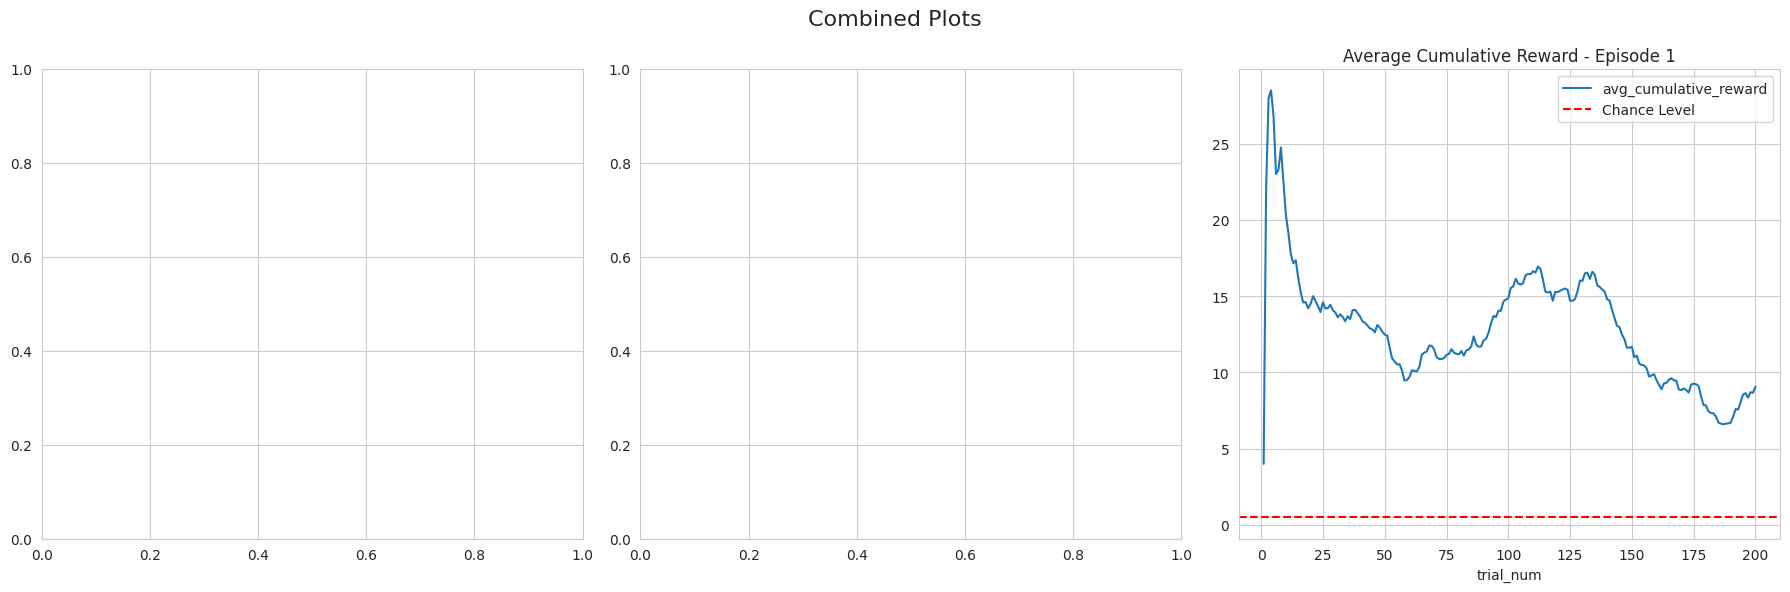

In [ ]:
episode = 1  # Change this to see other episodes
data = df_untrained[df_untrained['episode'] == episode]
plot_combined_single(data, label=f'Episode {participant_id}', title='Combined Plots')

In [ ]:
# Compare element-wise
comparison = df_trained['score'] > df_untrained['score']

print(comparison)
# Count how many times df trained has better scores
dfTrained_better = comparison.sum()

# Count how many times df untrained has better scores
dfUntrained_better = (~comparison).sum()

print(f"df trained has better scores {dfTrained_better} times.")
print(f"df untrained has better scores {dfUntrained_better} times.")


0        False
1        False
2        False
3        False
4        False
         ...  
19995     True
19996     True
19997     True
19998    False
19999    False
Name: score, Length: 20000, dtype: bool
df trained has better scores 11227 times.
df2 has better scores 8773 times.


In [ ]:
# Calculate the sum of scores
df1_total = df_trained['score'].sum()
df2_total = df_untrained['score'].sum()

print(f"df trained total score: {df1_total}")
print(f"df untrained total score: {df2_total}")

# Determine the better DataFrame
if df1_total > df2_total:
    print("df trained has better overall scores.")
else:
    print("df untrained has better overall scores.")


df trained total score: 24575104
df untrained total score: 23914061
df trained has better overall scores.


In [ ]:
# Import necessary libraries
import gymnasium as gym  # Using Gymnasium, a new fork of Gym.
from enum import Enum  # For defining Enum classes to handle discrete actions and grid tiles.
import random  # For generating random numbers in the environment.
import numpy as np  # For numerical operations, especially with arrays.
from scipy.stats import norm  # For generating random numbers with normal (Gaussian) distribution.
from os import truncate  # For file operations, although not used here.

# Define the possible actions for the agent (either LEFT or RIGHT).
class AgentAction(Enum):
    LEFT = 0
    RIGHT = 1

    # Method to return the value (integer) associated with each action.
    def get_value(self):
        return self.value

# Define grid tiles that will represent different objects in the environment (agent, spaceships, aliens).
class GridTile(Enum):
    Agent = 0
    Green_Spaceship = 1
    Blue_Spaceship = 2
    Turquoise_Spaceship = 3
    Orange_Spaceship = 4
    Red_Alien = 5
    Purple_Alien = 6

    # Method to return the first three letters of the tile's name when printed.
    def __str__(self):
        return self.name[:3]

    # Method to return the numeric value of the tile (used for internal representation in state).
    def get_value(self):
        return self.value


# The main task class for the two-step task.
class Two_Step_Task:
    # Initializes the grid dimensions and other task parameters.
    def __init__(self, grid_rows=3, grid_cols=3, fps=1):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.reset()

    # Resets the environment at the start of each episode.
    def reset(self, seed=None):
        random.seed(seed)  # Make randomness reproducible by using a seed.

        # Initialize the state (a vector with four elements: [stage, left stimulus, right stimulus, reward-related state])
        self.state = [0, 0, 0, 0]  # Stage 0: no state or stimuli yet
        self.assign_stimulus()  # Assign random stimuli and state to the agent

        # Initialize positions for rendering
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]

        self.generate_rewards()  # Generate the reward matrix
        self.trial_num = 0  # Initialize trial number
        self.winning_prob_matrix = []  # Matrix for reward probabilities
        self.stake = 1  # Initial stake (affects reward magnitude)
        self.score = 0  # Initial score

    # Resets the environment for a new trial.
    def reset_trial(self):
        self.state = [0, 0, 0, 0]  # Reset at the start of a new trial
        self.assign_stimulus()  # Assign new stimuli
        self.left_stim_pos = [0, 0]
        self.right_stim_pos = [0, 2]
        self.agent_pos = [2, 1]

    # Generate reward probabilities, with Gaussian noise added over time.
    def generate_rewards(self):
        self.bounds = [0, 9]  # Reward bounds (change if necessary)
        self.sd = 2  # Standard deviation for reward noise
        self.choices = 1  # Number of choices (only one in the novel task)
        self.nrtrials = 200  # Number of trials

        self.bounds = np.sort(self.bounds)  # Ensure bounds are sorted

        # Initialize reward matrix with zeros
        self.rewards = np.zeros((self.nrtrials, 2, self.choices))

        # Generate initial reward probabilities based on random values
        if np.random.rand() < 0.5:
            if np.random.rand() < 0.5:
                x = np.array([0, 4])  # reward probabilities
            else:
                x = np.array([4, 0])
        else:
            if np.random.rand() < 0.5:
                x = np.array([[5, 9]])  # Another set of probabilities
            else:
                x = np.array([[9, 5]])

        self.rewards[0, :, 0] = x  # Assign the generated values to the first trial

        # Loop through each trial and apply Gaussian noise to rewards.
        for t in range(1, self.nrtrials):
            for s in range(2):  # Two states in the environment (left and right stimulus)
                for a in range(self.choices):  # Number of actions (choices) in each state
                    # Add Gaussian noise to the reward from the previous trial
                    self.rewards[t, s, a] = self.rewards[t-1, s, a] + norm.rvs(scale=self.sd)
                    # Make sure rewards stay within the specified bounds
                    self.rewards[t, s, a] = min(self.rewards[t, s, a], max(self.bounds[1] * 2 - self.rewards[t, s, a], self.bounds[0]))
                    self.rewards[t, s, a] = max(self.rewards[t, s, a], min(self.bounds[0] * 2 - self.rewards[t, s, a], self.bounds[1]))

        self.rewards = np.round(self.rewards, 3)  # Round the rewards to 3 decimal places for accuracy
        return self.rewards

    # Reset the stake value randomly (either 1 or 5).
    def reset_stake(self):
        p = random.random()
        self.stake = 1 if p <= 0.5 else 5

    # Assign random stimuli (spaceships) to the agent.
    def assign_stimulus(self, stim_1=GridTile.Green_Spaceship, stim_2=GridTile.Blue_Spaceship,
                        stim_3=GridTile.Turquoise_Spaceship, stim_4=GridTile.Orange_Spaceship):
        p = random.random()
        if p <= 0.5:
            p = random.random()
            if p <= 0.5:
                self.left_stim = stim_1
                self.right_stim = stim_2
            else:
                self.left_stim = stim_2
                self.right_stim = stim_1
            self.state = [1, 0, 0, 0]
        else:
            p = random.random()
            if p <= 0.5:
                self.left_stim = stim_3
                self.right_stim = stim_4
            else:
                self.left_stim = stim_4
                self.right_stim = stim_3
            self.state = [0, 1, 0, 0]

        # Update the state to reflect the chosen stimuli values.
        self.state_part2 = [self.left_stim.get_value(), self.right_stim.get_value()]

    # Assign planets (rewards) to the agent based on the spaceship type.
    def assign_planet(self, space_ship: GridTile):
        p = random.random()
        match space_ship:
            case GridTile.Green_Spaceship:
                self.state = [0, 0, 1, 0]  # Assign red planet
                self.state_part2 = [GridTile.Red_Alien.get_value(), 0]
            case GridTile.Blue_Spaceship:
                self.state = [0, 0, 0, 1]  # Assign purple planet
                self.state_part2 = [0, GridTile.Purple_Alien.get_value()]
            case GridTile.Turquoise_Spaceship:
                self.state = [0, 0, 1, 0]  # Assign red planet
                self.state_part2 = [GridTile.Red_Alien.get_value(), 0]
            case GridTile.Orange_Spaceship:
                self.state = [0, 0, 0, 1]  # Assign purple planet
                self.state_part2 = [0, GridTile.Purple_Alien.get_value()]

    # Perform the action (LEFT or RIGHT) and update the state accordingly.
    def perform_action(self, agent_action: AgentAction):
        if agent_action == AgentAction.LEFT:
            self.assign_planet(self.left_stim)
        if agent_action == AgentAction.RIGHT:
            self.assign_planet(self.right_stim)

        # Retrieve the reward based on the current state and action.
        reward_ind_state = self.state.index(1) - 2
        reward_ind_action = 0
        self.reward_prob = self.rewards[self.trial_num, reward_ind_state, reward_ind_action]
        self.winning_prob_matrix = self.rewards[self.trial_num, :, :]

        # Increment the trial number if it's less than the total number of trials.
        if self.trial_num <= 199:
            self.trial_num += 1

    # Print the current state of the environment for visualization.
    def render(self):
        for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                if [r, c] == self.agent_pos:
                    print(GridTile.Agent, end=' ')
                elif [r, c] == self.left_stim_pos:
                    print(GridTile(self.left_stim), end=' ')
                elif [r, c] == self.right_stim_pos:
                    print(GridTile(self.right_stim), end=' ')
                else:
                    print(' ', end=' ')
            print()

# Custom Gym environment for the two-step task, inheriting from gym.Env
class TwoStepTaskEnv(gym.Env):
    # Define metadata for the environment
    metadata = {"render_modes": ["human"], 'render_fps': 1}

    def __init__(self, grid_rows=3, grid_cols=3, render_mode=None):
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.render_mode = render_mode
        self.input_size = 8

        # Initialize the task agent for the two-step task
        self.task_agent = Two_Step_Task(grid_rows=grid_rows, grid_cols=grid_cols, fps=self.metadata['render_fps'])

        # Define the action space (number of possible actions: LEFT and RIGHT)
        self.action_space = spaces.Discrete(len(AgentAction))

        # Define the observation space (an array of 8 integers)
        self.observation_space = spaces.Box(low=0, high=4000, shape=(self.input_size,), dtype=np.int64)

    # Reset the environment to the initial state
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ensure reproducibility
        self.task_agent.reset(seed=seed)

        # Create the initial observation
        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((self.input_size,))

        info = {}  # Additional info (if needed)

        if self.render_mode == 'human':
            self.render()

        return obs, info

    # Render the current state of the environment
    def render(self):
        self.task_agent.render()

    # Step function to perform an action and return the new state, reward, etc.
    def step(self, action):
        # Perform the chosen action
        self.task_agent.perform_action(AgentAction(action))

        # Calculate the reward and determine if the trial has terminated
        reward = int(self.task_agent.reward_prob) * self.task_agent.stake
        self.task_agent.score += reward
        self.task_agent.reset_stake()
        self.task_agent.reset_trial()

        terminated = self.task_agent.trial_num >= 200  # Terminate after 200 trials

        # Create the new observation
        observation = self.task_agent.state + self.task_agent.state_part2 + [self.task_agent.stake] + [self.task_agent.score]
        obs = np.array([observation], dtype=np.int64).reshape((self.input_size,))

        info = {
            'number of trials': self.task_agent.trial_num,
            'stake': self.task_agent.stake,
            'winning_matrix': self.task_agent.winning_prob_matrix
        }

        return obs, reward, terminated, False, info

# Register the custom environment with Gymnasium
register(
    id='two-step-task-novel-v0',  # Environment ID
    entry_point=TwoStepTaskEnv,   # Class name for the environment
)


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment two-step-task-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
